<a href="https://colab.research.google.com/github/quangviet/python4engineer/blob/main/Problem_1/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Comprehensive Tutorial To Understand EDA + Time Series Analysis + TimeSeries Forecasting SARIMAX & Prophet

#**Bài 1 - Python for Developers (MSE):**

Đọc hiểu tutorial One Tutorial to Understand All (M5-Forecasting) trên Kaggle và chú thích lại bằng tiếng Việt.

## **Về cuộc thi M5-Forecasting**

Cuộc thi sử dụng data thu thập được từ dữ liệu thực tế của Walmart để dự báo lượng bán hàng trong 28 ngày tiếp theo.
Dữ liệu bao gồm khoảng 30,000 mặt hàng bán trong 1,900 ngày từ 3 bang của nước Mỹ. Các thông tin bao gồm giá, khuyến mãi, thời gian và các thông tin bổ sung khác như loại hàng hoá, cửa hàng etc.

## **Mô tả vấn đề:**

Để có thể dự đoán được lượng hàng hoá bán ra trong 28 ngày tiếp theo, các câu hỏi dạng SMART sau cần được trả lời trước.

- Phân phối của sales_items(ids) theo từng categories?
- What is the behavior of categories across different stores?
- What specific item id is outselling the most? 
- What is the specific id of item in each category that has most sales?
- What is the most sales revenue collected? Is the item id that is outselling the most brings in the most revenue or is there variation along those trends?
- What is the behavior of total sales (or mean sales) across time
- What is the behavior of item_ids selling across different weekdays? Are there any specfic dates of the month when there are most sales?How does this trend change across different stores?

Do đề bài chỉ dừng lại ở bước trực quan hoá dữ liệu, mô hình dự đoán lượng hàng bán ra chưa được đề cập đến trong notebook này.

### Chỉ số đo lường:

Các chỉ số sau được dùng để đo đạc các sai số 

This project uses quite a few error metrics that have been used to either optimise and fine tune the model or to find the prediction accuracy for the forecast made using time series. Given the situation of the time series forecast that we are gong to make, there are following error metrics used. 

1. **RMSE (Root Mean Square Error)** - In order to evaluate the sales forecasts made using SARIMAX, RMSE error metric was used. The Time series used in this case, took the average number of sales made, along the course of almost 1900 days, dsregarding the original heirarchical data arragement of product ids alongside several other levels. The utitlity of the error metrc RMSE is not invalidated since, we are considerng the average number of sales made, thereby nullyfying the effect of lots of zeroes for a lot of product ids, alongside only the number of days. 

2. **Custom Loss (WMAPE)**: The error metric Weighted Mean Absolute Percentage Error was used to evaluate and find the optimal parameters for the Facebook Designed Prophet Model. The WMAPE error is used for those instances where the priority of each product id is considered alongside the number of sales made. The weighted coefficients were calculated by dividing the difference between the forecast and the actual sales values by their mean value. 

3. **WRMSSE (Weighted Root Mean Square Scaled Error)** : In order to evaluate the efficiency of the model designed, the WRMSSE score was calculated once the prediction ready dataframe (forecast of almost 30,000 product ids) was ready. This was necesary because the WRMSSE score calculated required that the total entries of all product ids (almost around 30,000 products) be used and then a difference between the values of the validation dataset i.e. sales_train_validation.csv and the forecasted dataframe was taken. This WRMSSE error metric is the one that is provided by the competition and has been optimised to be used for the current competition. I order to evaluate it, we would have to use the whole dataset of sales_train_validation.csv that has been provided in single csv file. Further explanation for this error can be found at https://mofc.unic.ac.cy/m5-competition/



### Chuẩn bị các thư viện

Notebook này sử dụng các thư viện 
- Numpy - Xử lý dữ liệu mảng và đại số tuyến tính
- Pandas - Xử lý dữ liệu bảng và file csv
- Matplotlib - Trực quan hoá dữ liệu lên đồ thị
- Seaborn - Trực quan hoá dữ liệu thống kê
- Scipy - Thư viện khoa học, toán học
- Sklearn - Thư viện học máy
- Plotly - Vẽ đồ thị trực quan

Và một số thư viện hệ thống như time, math, datetime và các widget dùng để tương tác trực tiếp trong notebook


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


#### Dataset Description:

The description of the data files that are imported into this notebook is as follows:

* `calendar_df.csv` - Contains information about the dates on which the products are sold and also contains information about the holidays and special occasions.
* `train_sales_df.csv` - Contains the historical daily unit sales data per product and store and department id with almost a data of sales for 1900 days [d_1 - d_1913] 
* `submission_file.csv` - The correct format for submission file, containing the product ids and the column ids for the next 28 days sales data forecast. 
* `sell_prices_df.csv` - Contains information about the price of the products sold per store and date.
* `sales_train_evaluation.csv` - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)


#### Importing the Datasets:

In [ ]:
sell_prices_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
train_sales_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
submission_file = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')


### Understanding the DataSet:

In [ ]:
sell_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [ ]:
train_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [ ]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


Now that we have taken a look at the data provided and have a general understanding of the dataset, we can see various relationships between the stores, the specific products sold, the categories that the consumers are most interested in as well as the sale of items per specific locale. Sell_prices_df contains information along the store level of some 6 million entries while the train_sales_df has informaiton about some 30,000 different products. 

Furthermore, the dataset in the calendar_df makes it possible to do a time series analysis of the products sold. 

## *EDA (Exploratory Data Analysis):*

### Questions on Distribution of Product & Behavior Across Timeline

Starting with the dataframe denoted by train_sales_df that has the item specific ('id'), locale specific ('store_id' , 'state_id') and sales days specific (d_1 to d_1913) information; let us first make necessary adjustments to separate the sales days so that analysis along item_id, store_id and dept_id can be more easily observed across sales days only. 

In [ ]:
train_sales_df.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [ ]:
d_cols = [c for c in train_sales_df.columns if 'd_' in c]
train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
train_sales_df['avg_sales_all_days'] = train_sales_df[d_cols].mean(axis = 1)
train_sales_df['median_sales_all_days'] = train_sales_df[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

#### Distribution of Product_ids Across Categories?

In [ ]:
df = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of Product_IDs Across Categories')
fig.show()

Food items are the most sold out item that are followed by household items and then hobbies items.

In [ ]:
df = train_sales_df.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
fig = px.pie(df, values='total_sales_all_days', names='state_id', 
            color_discrete_sequence=px.colors.sequential.Aggrnyl,
            width = 750, height=450, title = 'Distribution of Total_Sales Across States')
fig.show()

With respect to the total number of sales, it is evident once again that the number of items sold on total have the greatest contributing share in CA, followed by Texas and Wisconsin. Now is it the case with the total revenue generated as well? We'd find that out using the revenue dataframe 

In [ ]:
df1 = train_sales_df.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = train_sales_df.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

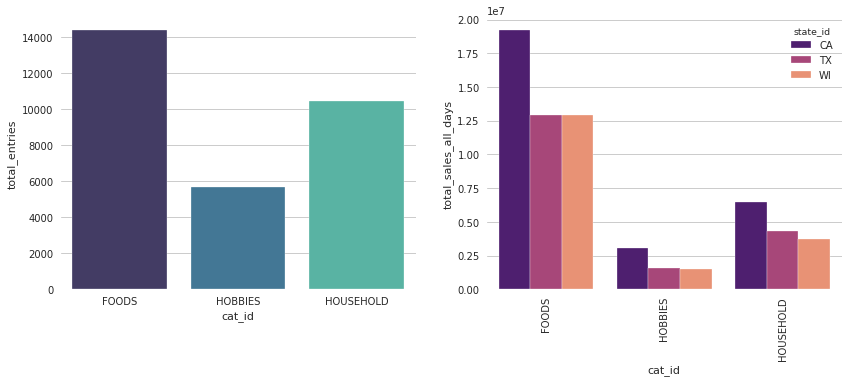

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

The above two plots indicate:
- Most items sold belong to the FOODS category, followed by HOUSEHOLD and HOBBIES
- CA leads in the number of "Total items" sold in either category (FOODS, HOBBIES AND HOUSEHOLD) , while WISCONSIN lags behind TX in each category except FOODS. We would see whether the same difference translates in terms of revenue extracted off these states or not

In [ ]:
#df3 = train_sales_df.groupby(['cat_id', 'store_id'])['total_sales_all_days'].sum().reset_index()

In [ ]:
#sns.set_style('whitegrid')
#sns.axes_style(style='ticks')
#fig, ax1 = plt.subplots(figsize=(14,5))

#sns.barplot(x = 'store_id', y='total_sales_all_days', hue='cat_id', data=df3, 
#            palette='afmhot', ax=ax1)

#plt.xticks(rotation=90)
#plt.show()

Same results across all stores

In [ ]:
df = train_sales_df.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

A couple of points that could be drawn from this observation are:
- most items have been sold in california
- Texas and Wisconsin stores have almost total sales i.e. during the same timeframe of 1913 days, same number of items had been sold in both Texas and Wisconsin. Would this observation hold true in the sell_prices_df (revenue dataset) ? Does the observation remain same across different store locations in both Texas and Wisonconsin?

#### Distribution of Items Across Department & Store_ids?

In [ ]:
df = train_sales_df.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[train_sales_df.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [ ]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

The data_analysis on these points helps make it clear that:
- Regarding the distribution of sales across department ids, most sales have been made across "FOODS_3" category followed by most sales made across household_1 category
- Stores locale identity along with embedded state_ids helpe make it clear that the distribution of sales across Texas & Wisconsin stores are NOT the same , though the total number represented across categories (foods, houshold and hobbies) might have come the same.
- The outperformers in Each state of CA, TX and Wisonsin are the stores with ids CA_3, TX_2 and WI_3 respectively

#### Specific Item OutSelling the Most?

Since the train_sales_df contains the information about each specific item and the number of sales made, we can make a few observations regarding the most frequently purchased item too.

We could plot its behavior across the number of days to get a general gist of its sales pattern across given days. i.e d_1 to d_1913

In [ ]:
train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_057_WI_2_validation            16
FOODS_2_071_TX_3_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Once the total number of sales have been grouped against specific item id i.e. 'id' parameter, it is clear that the item "**FOODS_3_090_CA_3_validation**" has clearly sold most units than any other item in the category followed by **"FOODS_3_586_TX_2_validation"**. i.e. the first item belongs to food_3 category and sold in the CA_3 store location. Similarly, the second one belongs to TX_2 store location (i.e. second store in Texas) also belonging to the same category of FOODS_3 which is also consistent with observations made before

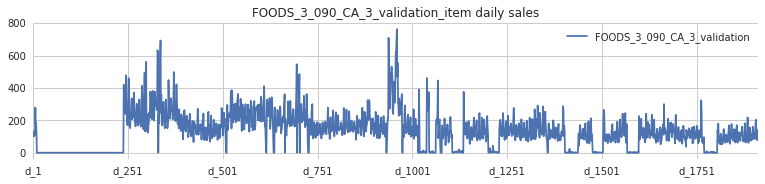

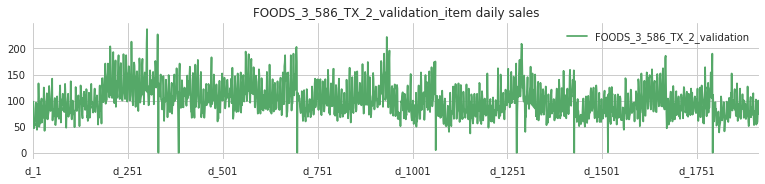

In [ ]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    train_sales_df.loc[train_sales_df['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Item ID Outselling Most in Each Category?

In [ ]:
df_agg = pd.DataFrame(train_sales_df.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

,id,cat_id,store_id,total_sales_all_days
0,FOODS_3_090_CA_3_validation,FOODS,CA_3,250502
1,FOODS_3_586_TX_2_validation,FOODS,TX_2,192835
2,FOODS_3_586_TX_3_validation,FOODS,TX_3,150122


Now that the dataset has been arranged in descending order of total sales, it would be a lot easier to estimate the item_id ('id') outselling others in each category

In [ ]:
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [ ]:
#df = pd.DataFrame({"days": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].columns),
#                   "sales_data": list(train_sales_df[train_sales_df['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].values.flatten())})

In [ ]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(train_sales_df[train_sales_df['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

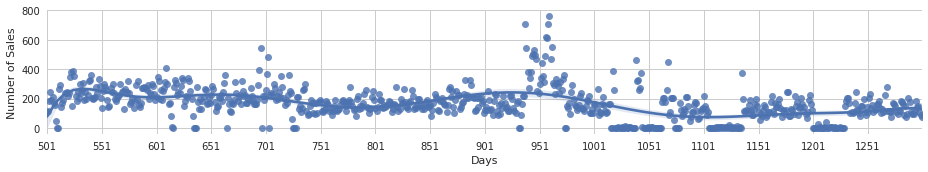

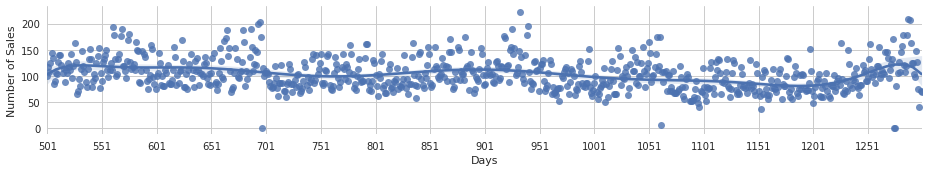

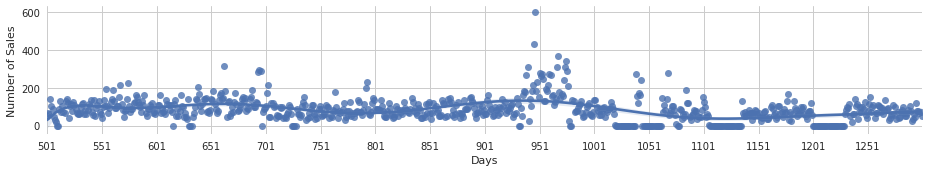

In [ ]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)


Looking at the above graphs, our regression model does a fairly good job of fitting the line on the sales trend observed between the days 500th to 900th, for the item ids 'FOODS_3_090_CA_3_validation' and 'FOODS_3_586_TX_2_validation'. The graph also points out to the similar trends of troughs and crests between the specific days pointing out towards the occurence of special occasions and events that are driving sales. (To do _explain on order of polynomial and take more cases of ids across foods, household categories across different stores)

### Questions on Sales Revenue?

First of all, we'd be interested in finding out what the specific revenue with respect to each product is? But since we have not been provided the dataset with ids (product_ids) in sell_prices_df(revenue dataframe) and there is a mismatch in dataset entries between the both datasets (train_sales_df with almost 30000 rows and sell_prices_df with almost 6M entries), therefore, atbest, a rough estimate could be made by merging both datasets.

Frotunately enouhg, Revenue Dataframe (sell_prices_df) has the categorical level data available, so we could make an estimation regarding the items sold in each category to see what is the specific price where most items are getting sold. 

We'll first try fitting the non-parametric method of probability distribution since we suspect the data distribution might not be exact replica of a distribution we have seen before, and may include peaks or outliers. (https://machinelearningmastery.com/probability-density-estimation/)

If the behavior of data distribution does not resemble a known distribution, further investigation would be made to remove the specific data outliers

In [ ]:
sell_prices_df.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


In [ ]:
# making a new column category out of the item_id 
sell_prices_df['category'] = sell_prices_df['item_id'].str.split("_", expand=True)[0]

#### Distribution of Price Among Categories?

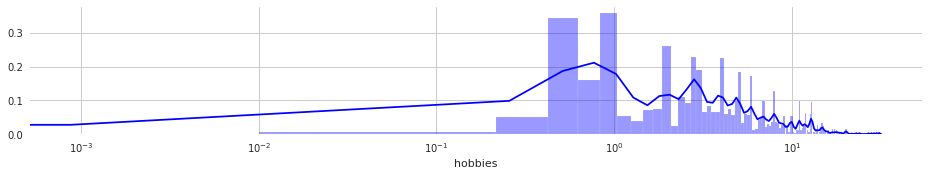

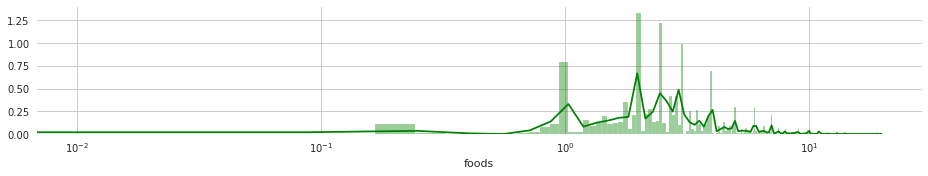

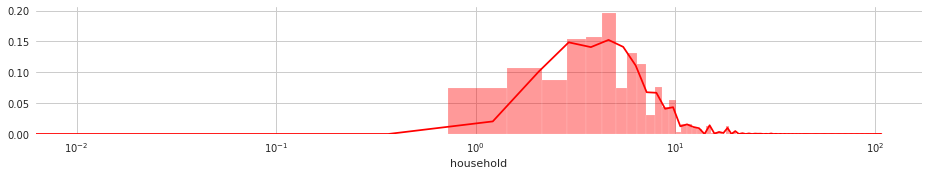

In [ ]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(sell_prices_df, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(sell_prices_df, 'FOODS', 250, 'g', 'foods') 
kde_plotting(sell_prices_df, 'HOUSEHOLD', 150, 'r', 'household') 

We could extract following useful information by looking at these kde plots. 

- The probability distribution plot of the **household** items follows an almost normal distribution with a mean centered around a price of 5 Dollars and most items being sold within the 1 to 10 dollars range. This would indicate that most household items that are getting sold lie within the price bracket of 25 cents to 10 dollars
- **Foods** items prices is a multimodal distribution indicating frequent variation in interest among food items purchased. The values occur both towards the relative higher price bracket as well as lower price bracket indicating that the degree of interest of consumers in food items is not only varied but that the Walmart stores have a catalogue of food items that are peaking consumer's interest across different categories. The price bracket in this case also happens to lie within 2 cents to 10 dollars with only very few items getting sold past that range
- The probability distribution of **hobbies** related items prices indicates a mix of bimodal and multimodal distributions. This indicates that while a few items in specific category were sold more than others (first peak that lies in the area between 0.01 dollar to 1 dollar) there are also items towards a relative higher price bracket that have been also sold quite frequently enought to give it a multimodal distribution with small decreasing peaks indicative of decreasing interest in hobbies related items that are relatively expensive but sill significant enough to generate consumer interest. 

#### Removing Outliers to Observe Price Distribution? 
#### **Quartile Method**

In [ ]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = sell_prices_df[['category', 'sell_price']]
df = remove_outliers(df)

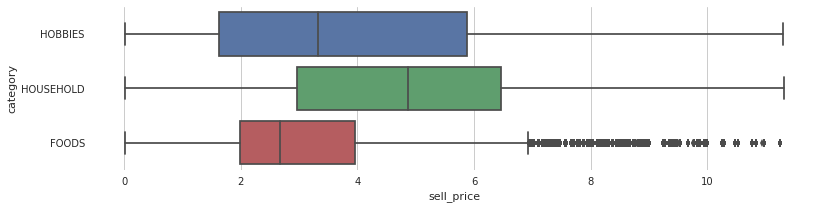

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

After removing most of the outliers, it is apparent that for 
- FOODS related items, 75 % of the items sold are those that are less than 4 dollars
- HOBBIES related items, 75 % of the items sold were less than 6 dollars with an mean price centered around 3.25-3.5 dollars
- HOUSEHOLD items, 75 % of the items sold were less than 6.5 dollars. 

It also represents that there are quite a few outliers in our price data. Since we had observed before using the kdeplots, that the distributions of the dataset were mostly skewed, we used the quartile method of removing the outliers. 

(https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/)

### Distribution of Sales On Weekdays & Special Occasions?

Our third dataset named, calendar_df, provides valuable information along the timeseries for the dataset of product_id. This dataset also contains information about Special occasions, SNAP (Supplementary Nutrition Assistance Programme) in the USA and coupled with the product_id dataset i.e. train_sales_df would be helpful in observing sales along weekdays, specific dates and special occasions

In [ ]:
calendar_df.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
calendar_df.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

Looking at the distribution of data in 'event_name_1' and 'event_type_1' it is clear the data here relates to holidays which could reveal important trends when coupled with the information of sales made on the specific event.

In [ ]:
calendar_df.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

It seems a few entries that have not been made to the 'event_name_1' attribute have been made available in a different category

In [ ]:
#Making in and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

calendar_df['days'] = [d.split('-')[2] for d in calendar_df['date']]
calendar_df['events_names'] = pd.concat([calendar_df['event_name_1'], calendar_df['event_name_2']], 
                                        ignore_index=True)
calendar_df['events_types'] = pd.concat([calendar_df['event_type_1'], calendar_df['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

#### What are **SNAP_CA, SNAP_TX, SNAP_WI**?

SNAP stands for "Supplementary Nutrition Assistance Program" that is a federal level program aimed at providing food essentials to low-income households. This program is geared towards providing the food essentials and within the current dataset, the catagories of household items and hobbies items do not fall within the requirements of this program.

This program is only geared towards fighting the food hunger in america and only food related items can be purchased under this program

In [ ]:
df = calendar_df.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

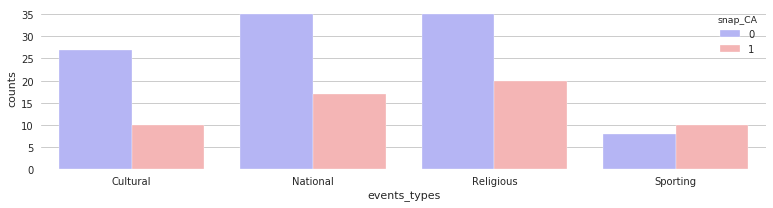

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [ ]:
df = calendar_df.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

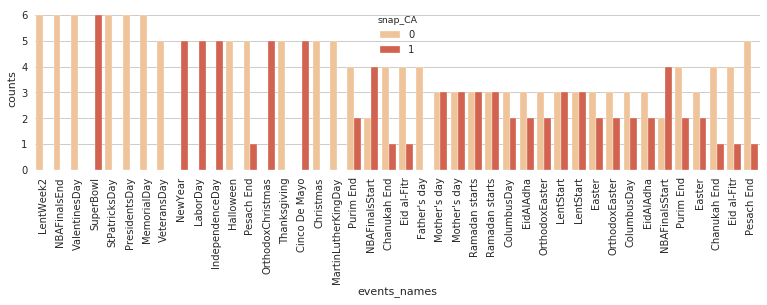

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

A look at both of these plots indicates the special occasions when the SNAP programme in CA were availed.  

### Distribution of Sales Items vs Sales Revenue? 
Now that we have product_id df as well as revenue_df, we'll merge the dataset now to start exploring trends of item_specific_data and sale_price_specific data 

In [ ]:
#product id df (train_sales_df) vs revenue_df(sell_prices_df)
train_sales_prices_df = train_sales_df.merge(sell_prices_df, how='inner', on='item_id', 
                                            left_index=True, right_index=True, 
                                            validate="1:1")


In [ ]:
df = train_sales_prices_df.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

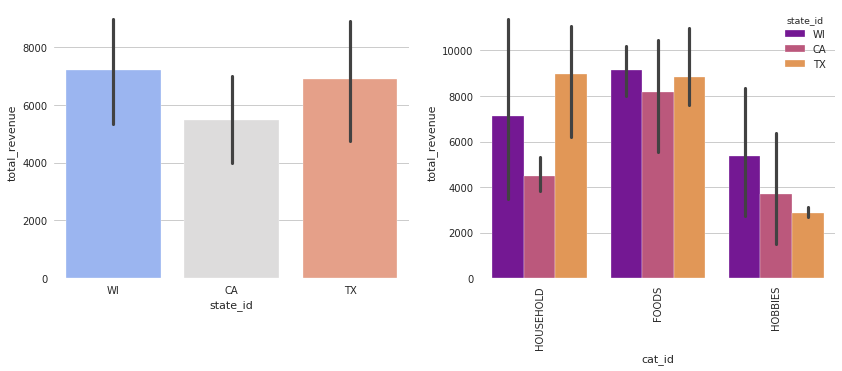

In [ ]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

Despite the fact that salesprices data contains almost 6M entries, in the present case, we are only considering common entries between revenue df and product_ids df. A few significant insights have come forward, i.e. 

- Although we saw that california consistently was the one state where the unique product_id most sales were made, the most revenue collected came from the Wisconsin State stores
- Similarly, within the distribution of Categories, WI and TX contrinute more sales revenue than do the CA stores. 
- Wisconsin leads the revenue in FOODS and HOBBIES, while Texas leads the revenue in HOUSEHOLD
- CA tends to contribute the smallest revenue out of all three states, despite having the most sales of items in its stores locations

%%%%^^^^^^^^^!!!^^^^^^^^^%%%%%

In [ ]:
#train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d'), 
 #                                                                   left_index=True, right_index=True,
 #                                                                   validate="1:1").set_index('date')


In [ ]:
##train_sales_cal_df.T

### *Behaviour on TimeSeries & Analysis?*

Timeseries questions would involve merging the datasets of product_ids and data information to enable a thorough analysis through time. We could find out information on the sales of items alongside the timeseries and also find out what specific effects, the weekends and specials occasions might have had on number of units sold

**Rolling Averages** : Rolling averages are a useful tool to employ to understand the long term effects in a timeseries represented data. The rationale behind using rolling averages is the fact that resulting reading coming out of rolling averages smoothes out the data against daily fluctuations, and could help data professionals understand the long term impact of the sales/inventory across time. Therefore, we are going to use both rolling average as a necassary tool to help aid ou

#### Distribution of Total Sales Against Product_id on TimeSeries?

In [ ]:
#Changing the date type to datetime so that it is depicted as so:

#calendar_df.date = pd.to_datetime(calendar_df.date)
#type(calendar_df.date)

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [ ]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [ ]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

From this graph it is difficult to tell the trend and seasonality patterns within our dataset. Althogh there is an increasing trend, the number of values for the entire dataset represented in the graph make it difficult to ascertain the true picture.

Fortunately, using the seasonal_decompose module in statsmodel, we could find out the seasonality and trend patterns in the timeseries. We are going to choose the "mulitplicative seasonality" owing to the fact of variability in the magnitude of the number of sales along the timeseries


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

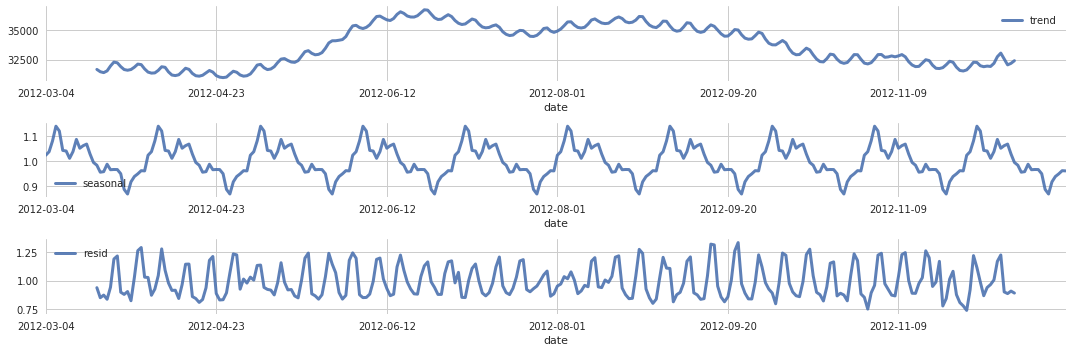

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

fter looking at the trend, the seasonality and residuals patterns, we have the following information gathered:

* There is definitely seasonality in our dataset, and in order to observe its pattern, we have taken a subset of dataset
* Since the seasonal and residual components are changing the trend line by an amount that is 'Dependent" of the changes in seasonal and residual components, we have a multiplicative behaviour

In [ ]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [ ]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

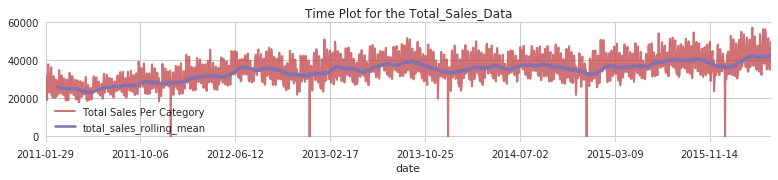

In [ ]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

Looking at the graph, it is obvious that the unit sales across timeline have been on a steady increase. This would imply that 

* There are items remaining in inventory must be tracked
* We could plot a sales of a few items to see how the behavior of each one fares across timeline. 

In [ ]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = train_sales_df.groupby(['id'])['total_sales_all_days'].sum(axis=1).sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,FOODS_3_090_CA_3_validation,250502
1,FOODS_3_586_TX_2_validation,192835
2,FOODS_3_586_TX_3_validation,150122
3,FOODS_3_586_CA_3_validation,134386
4,FOODS_3_090_CA_1_validation,127203


In [ ]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum(axis=1).sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

So, out of the most popular categories of 25 most sold items, more items had been sold in Texas than in either California or Wisconsin

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

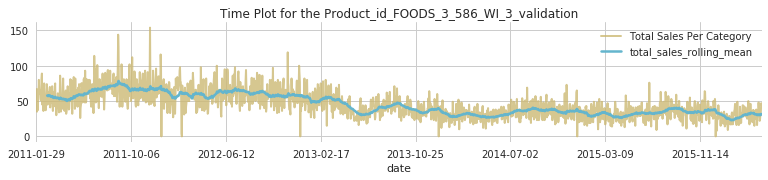

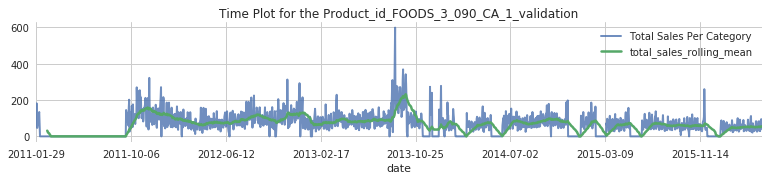

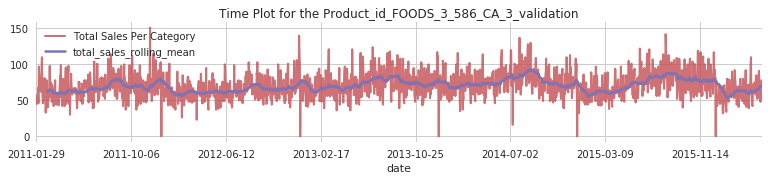

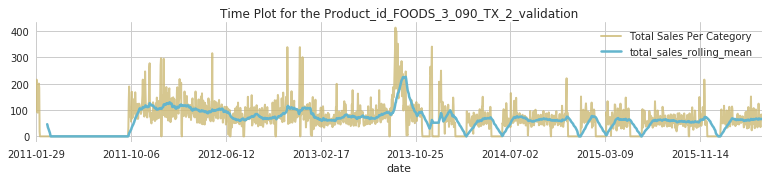

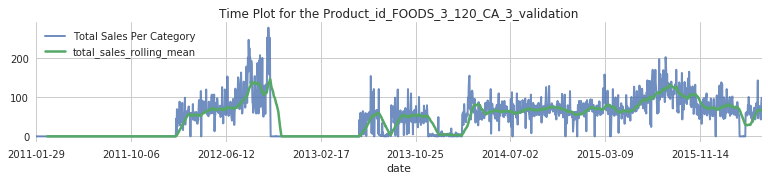

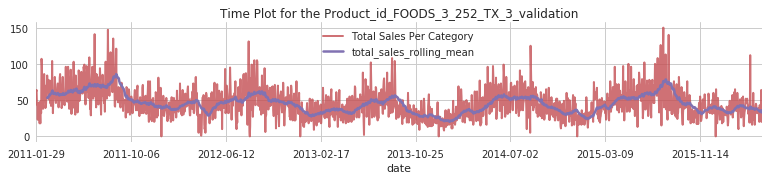

In [ ]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

### Distribution of Total Sales Against Each Category?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,23178,3764,5689
2011-01-30,22758,3357,5634


In [ ]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

The results of the plot indicate that:

* There is defintely an increase in the number of items being sold with time
* The items sold in the Food and Household category have seen a more gradual increase than those of hobbies related items.

#### Distribution of Total Sales Sold Per State?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['state_id'])[d_cols].sum(axis=1).T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

,CA,TX,WI
date,,,
2011-01-29,14195,9438,8998
2011-01-30,13805,9630,8314
2011-01-31,10108,6778,6897
2011-02-01,11047,7381,6984
2011-02-02,9925,5912,3309
...,...,...,...
2016-04-20,15148,9600,10595
2016-04-21,14488,9602,10943
2016-04-22,17095,10615,12807


In [ ]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

While there has been an increase in the number of sales across all three states i.e. CA, TX, and WI interesting to note is the fact that:

* There is an overall increase in the sales of items across all states
* WI sales cross TX sales at around Oct'14 and Sept'15 indicating that that could be boost in the sales of category of items that are seasonal. We'll try and investigate the sales of categories across separate states to further shed a light on this answer

In [ ]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = train_sales_df.groupby(['state_id', 'cat_id'])[d_cols].sum(axis=1).T\
              .join(pd.concat([calendar_df.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(2)

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:617: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



,"(CA, FOODS)","(CA, HOBBIES)","(CA, HOUSEHOLD)","(TX, FOODS)","(TX, HOBBIES)","(TX, HOUSEHOLD)","(WI, FOODS)","(WI, HOBBIES)","(WI, HOUSEHOLD)",dates
d_1,10101,1802,2292,6853,879,1706,6224,1083,1691,2011-01-29
d_2,9862,1561,2382,7030,870,1730,5866,926,1522,2011-01-30


In [ ]:
#train_sales_cal_df = train_sales_cal_df.set_index('dates')

In [ ]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

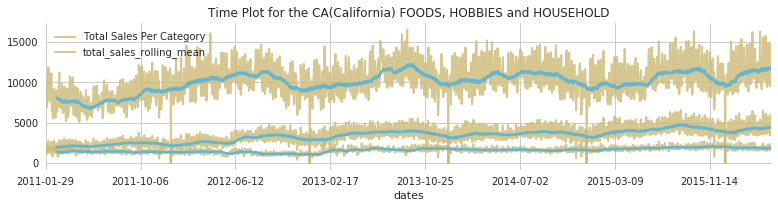

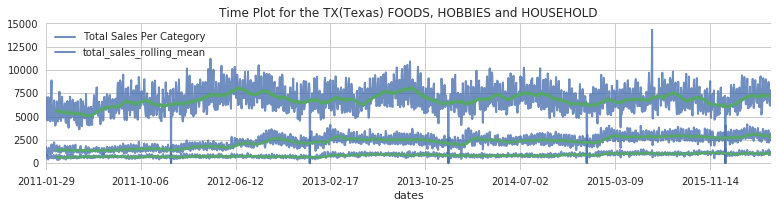

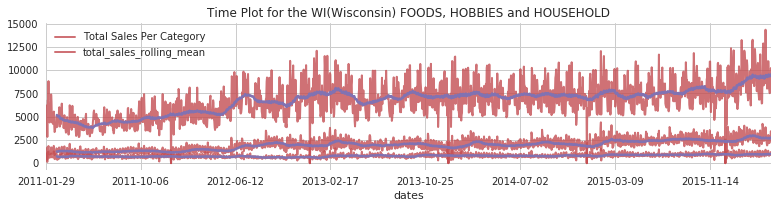

In [ ]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

By looking at the above graphs, some of the trends regarding in the food distribution category along separate states have become evident. 

* Along the FOODS distribution, both CA and TX see large bumps in sales around june'12 and september'12-October'12 with the next peak coming around in Oct'13 that is larger than the sales in June'12 with the same trend continuing to repeat itself along other dates in 2014, and 2015
* However, the sales along WI stores have a slightly different pattern with peaks of sales occuring in July'12 and next largest being observed in Feb-Mar'13. Similarly, the sales pick up around September in 2013, and then in Mar'13

* In Household items distribution, the peaks of sales across all stores in CA, TX and WI occur around July, March while relatively huge dips in sales occuring in all three locations around the month of Jan-Feb. 

* In Hobbies items sales, there is surprising peak in sales (albiet different in actual number of units sold) across similar dates in all store locations (for example Feb'13 and Feb'15) with a slight dip in sale in Aug-Sep'13.

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)


In [ ]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [ ]:

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [ ]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [ ]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


These are the five item ids that have been selling most in California and Texas locations.
* While the first one "FOODS_3_090_CA_3_validation" is the same as the one that was most sold during our earlier analysis, the second observation is quite different to earlier assessment and the item most sold in second place has id "FOODS_3_281_CA_3_validation"
* The items that were contributing to the sales bump of household items are also mentioned above. The household item sold most during the bump period is HOUSEHOLD_1_334_CA_3_validation 

### Distribution of Total Sales Vs Store_ID?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['store_id'])[d_cols].sum(axis=1)\
                                                .T.merge(calendar_df.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df.head(2)

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198


In [ ]:
#PLOT one by one to avoid memory overload

#plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
#plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

Looking at the above plot with respect to specific stores, it is indicative that:

* CA_3 store location has the most items sold
* CA_4 store location has the least items old across the timeline
* TX_2 has the most items sold across timeline with most items sales peaking around Sep'13
* All Texas store locations (TX_1, TX_2, TX_3) experience a boost in sales around Feb_Mar'15 , with a peak around August'15 and then bottom out around Dec'15
* Wisconsin Store locations experience a rather unpredictable pattern
* Store WI_2 accelerates past the sold of WI_3 in Dec'12 and then continues to maintain the lead
* Stores WI_2, WI_1 were underperformers in the beginning but experienced a boost in sales July'12 and November'12 respectively
* There appears to be a continuous decline in the performance of sold items for the store location WI_3 that are only relatively improved towards the end

### Distribution of Sales Per Specific Days/Weekends?

In [ ]:
train_sales_cal_df = train_sales_df.groupby(['cat_id'])[d_cols].sum(axis=1).\
                                                T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [ ]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(2)

,date,FOODS,HOBBIES,HOUSEHOLD,month,day,year,weekday
0,2011-01-29,23178,3764,5689,1,29,2011,Saturday
1,2011-01-30,22758,3357,5634,1,30,2011,Sunday


In [ ]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hob = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')


In [ ]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [ ]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_hob, 'HOBBIES')
heatmap_plot_dates(df_house, 'HOUSEHOLD')

## *Time Series Forecasting*

In time series forecasting, it is imperitive that the time series is stationary. A series is said to be stationary if its mean and variance remain constant over time. A time series forecasting requires that series be stationary so that any particular forecast will be more accurate if the current particular behavior over time is known. Should it be non-constant, there is high probability that the predictions made at one time would NOT be represented in series over some other time interval. 

Time series forecasting requires very specific criterion i.e.

1. Constant Mean
2. Constant Variance
3. an auto-correlation that does not depend on time

#### Stationary Time Series

Before we could make the time series stationary, we are going to need some form of a method where we could confirm that the time series extracted is indeed stationary. There are a few statistics test as well as we can plot the time series mean and variance as a function of time to observe that the series is indeed stationary. 

One of the time series stationary test is called the Dickey-Fuller Test. This test provides us with a test statistic as well as confidence intervals for the critical values. The objective is to determine whether the test statistic is less than the critical value, if it is we can **reject** the null hypothesis. The assumption of null and alternative hypotheses in this test is as follows:

* Null Hypothesis: The time series has some time component, and has a unit root suggesting a highly dependent time orientation indicating the presence of non-stationarity.
* Alternative Hypothesis: The time series does not have a unit root, indicating that it does NOT have a time dependent structure and consequently the time series is stationary.

In [ ]:
train_sales_cal_df = train_sales_df.set_index('id')[d_cols].T.merge(calendar_df.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)


In [ ]:
##train_sales_cal_df = train_sales_cal_df[['total_sales']]
##train_sales_cal_df = train_sales_cal_df.reset_index()
##train_sales_cal_df = train_sales_cal_df.set_index('date')

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)
train_sales_cal_df = train_sales_cal_df.set_index('date').asfreq('d')
train_sales_cal_df.head(2)

,daysnum,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,...,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation,avg_sales
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,d_1,0,0,0,0,0,0,0,12,2,...,14,1,0,4,0,0,0,0,0,1.070220
2011-01-30,d_2,0,0,0,0,0,0,0,15,0,...,11,1,0,4,0,0,6,0,0,1.041292


In [ ]:
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    rolling_mean = df.rolling(window=7).mean()
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #output = pd.Series(result[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
    #    output['Critical Value (%s)'%key] = value
    #print (output)

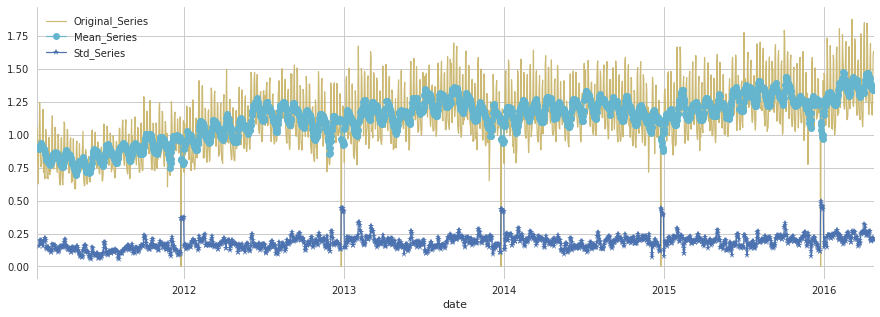


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

A few keypoints from the graph and the Dickey-Fuller tests indicate that:
* Mean series is increasing with time and is not constant so series is not stationary
* Standard deviation series also has quite a few deivations which indicates that the time series is not stationary
* ADF statistic is larger than the critical value which indicates that the series still has a unit root

#### **Methods For Making Time Series Stationary**
Since the time series has both seasonality and trend components, we are going to adopt methods that would remove both trend and seasonality. Methods that we are going to use include:

* **Differencing**
* **Decomposition**

##### **Differencing**

In order to perform this let us first take log , perform a log difference between the time series and its lag and look at the results

In [ ]:
df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
#df['sold'] = df_log_diff
#df['sold'] = df['sold'].dropna()
df_log_diff = df_log_diff.dropna()

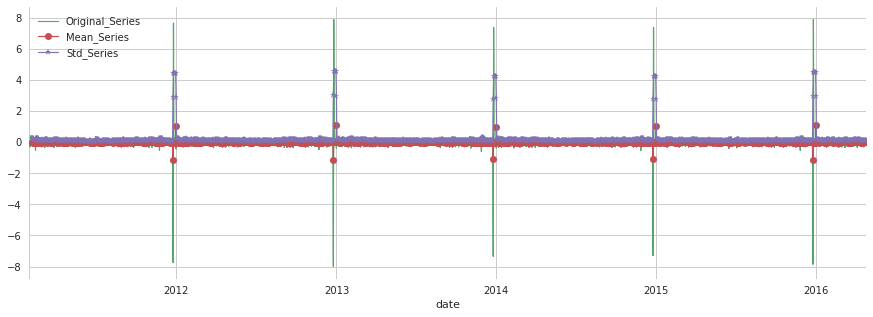


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -16.908187
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1885.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
time_series_stationary_test(df_log_diff)

We can observe that the test statistic value is less than even 1 % of the critical value, which indicates that we can reject the null hypothesis (that series is non-stationary) with 99 % confidence and p_value of 0 indicates that the test result is significant. 

#### **Decomposition**
Decomposition is another way to make the time series stationary. The decomposition of dataset yields three properties for the time series dataset

* Trend - That is whether there is an increase or decrease in total sales over long term
* Seasonality - Whether there are repeating patterns within the dataset
* Residual - What is the contribution of behavior in the time series dataset (total sales ) without trend and seasonality added

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):
    
    '''
    returns the trend, seasonality, and residual components decomposition of time_Series and
    plots the results 
    
    inputs: df(time_series df along with sales specified), model_specified (whether to use
            additive or multiplicative), period (number of days where seasonality 
            is to be observed)
    returns: decomposition plots along with decomposition components, in trend, seasonality
    and residuals
    '''

    df_decomposition = seasonal_decompose(
                               x=df, 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24))

    df.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax1)
    est_trend.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax2)
    est_seasonal.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax3)
    est_residual.plot(figsize=(14, 8) ,
                 alpha=0.6, 
                 lw=3, style = 'o', ax = ax4)

    fig.tight_layout()
    plt.show()
    
    return est_trend, est_seasonal, est_residual

#sample_time_s1 = train_sales_cal_df[400:700]
#est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 15)

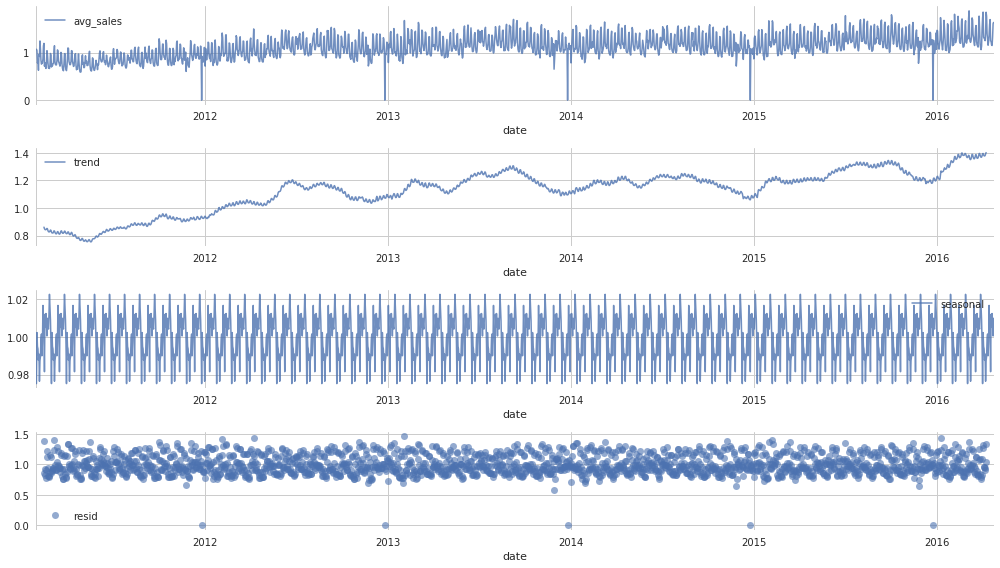

In [ ]:
trend_comp, seas_comp, residual_comp = time_series_decompose(train_sales_cal_df[['avg_sales']], 'multiplicative', 30)

The above results indicate that the presence of an increasing trend, as well as high seasonality in the time series being observed. The **residuals** are infact the component of the time series *without the seasonality and trend.*

Let's see what the results of the dickey-fuller test in decomposition are

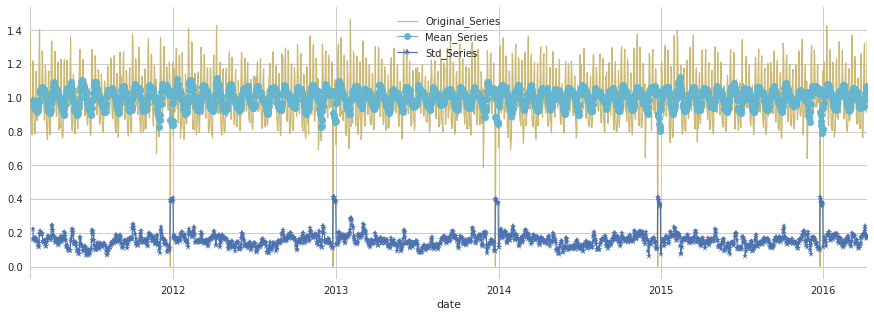


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -26.316735
No of lags: 25.000000
No of Obs used for ADF Calculation & Critical Values: 1857.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
residual_comp = residual_comp.dropna()
time_series_stationary_test(residual_comp)

The test statistic is less than 1 % of the critical value so we reject the null hypothesis with 99 % confidence and therefore, the time series is stationary

### **SARIMAX**
SARIMAX (Seasonal Auto-Regressive Integrated Moving Averages With Exogenous Factors) is an extension of the ARIMA model but one that is able to handle the seasonality component along with exogenous factors. i.e. holidays. 

ARIMA forecasting for a stationary time series is nothing but a regression equation. The prediction on the arima model is determined by its 'Trend' parameters p,d and q. They represent:

* Number of AR (auto-regressive) terms (p) : AR terms are just lags of the dependent variable. e.g. if p is 2, the predictors for x(t) will be x(t-1), x(t-2) OR AR terms view the value at one time as a weighted sum of past values.
* Number of MA (moving averages) terms (q) : MA terms are lagged forecast errors e(i) in prediction equation where e(i) is the difference between the moving avg at ith term vs the actual value. For q = 2, the predictors for x(t) will be e(t-1), e(t-2).
* Number of differences (d) : These are the number of non-seasonal differences. 

The SARIMAX adds other seasonal components to handle the seasonality with P, D, Q and m represpresenting the seasonal 'Auto-regressive' 'Differencing' and 'Moving-Average' Orders with m representing the number of time steps that are observing the seasonal behaviour. 

The equation for SARIMAX is given as SARIMAX (p, d, q) = (P, D, Q, S)

To find out the appropriate values for p and q, we generally employ ACF (auto-correlation function) and PCF (Partial-correlation function). 

* **ACF** - AutoCorrelationFunction: It is the measure of the correlation of a time series against lagged version of itself. e.g. with a lag of 3, ACF would compare the time instances t1, t2 with t1-3, t2-3
* **PCF** - PartialCorrelationFunction: It is a measure of correlation of a time series against a lagged version of itself but after removing the already calculated variations. e.g. with a lag of 4, PCF would check the correlation of against the lagged version but after removing the effects explained by lag1 to lag3 

In [ ]:
df_log_diff = np.log(train_sales_cal_df['avg_sales']) - np.log(train_sales_cal_df['avg_sales']).shift()
df_log_diff = df_log_diff.dropna()

### ACF & PACF: Finding Pdq Visually?

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

def auto_par_corr(ts_stat, nlags=25): 

    '''
    returns the ACF and PACF plots of the time series
    
    inputs: ts_stat (time series along with data), nlags (optimal number of lags)
    
    returns: plot of ACF and PACF
    '''
    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    #plt.plot(lag_acf)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    #lag_pacf.plot(figsize=(15, 5), alpha=1, 
    #                    lw=3, color=next(color_cycle), label='par_corr', ax=ax2)
    plt.subplot(122)
    #plt.plot(lag_pacf)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.legend()
    plt.show()
    

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



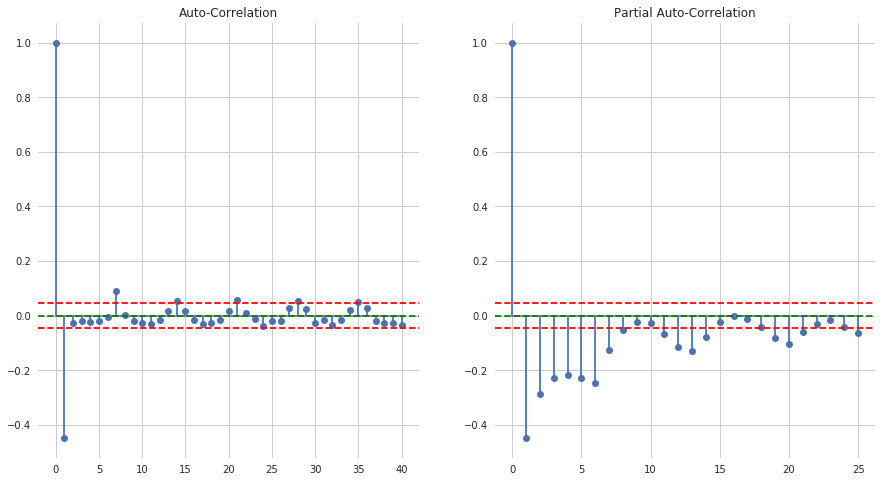

In [ ]:
auto_par_corr(df_log_diff, nlags=25)

A couple of things of note here are :

* In the first plot of autocorreation, the first significant value occurs at between 1 and 2, so therefore we are going to select q=1, while in the second plot of PACF, the significant value occurs at 2 so p=2
* In the ACF plot, we have regular peaks at interval of 7 so we are going to select the value of parameter m in seasonal order as 7, and since this lag is positive therefore the value for P=1, and for Q=0.
* As for value of d (differencing), we are going to select d as being 1 since we have taken a first order differencing, and since our seasonal pattern in ACF plot is stable we are going to choose value of D=1 (as opposed to D=0 when seasonal pattern is unstable) 

In [ ]:
#train_sales_cal_df.index = pd.DatetimeIndex(train_sales_cal_df.index.values,
#                               freq=train_sales_cal_df.index.inferred_freq)

In [ ]:
#Let us split the time series into training and testing sets
#perc_training = 0.7
#split_p = round(len(train_sales_cal_df['avg_sales']) * perc_training)
#training_p, testing_p = train_sales_cal_df['avg_sales'][0:split_p], train_sales_cal_df['avg_sales'][split_p:]

training_p = train_sales_cal_df.loc[:'2015-10-14', ['avg_sales']]
testing_p = train_sales_cal_df.loc['2015-10-15':, ['avg_sales']]
training_p.head(2)

,avg_sales
date,
2011-01-29,1.070220
2011-01-30,1.041292


#### Making Exogeneous Factors

In [ ]:
#for prophet model:
df_event_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar_df[~calendar_df['event_name_1'].isna()]['date']})
df_event_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar_df[~calendar_df['event_name_2'].isna()]['date']})
df_snapca = pd.DataFrame({'holiday': 'snap_CA', 'ds': calendar_df[calendar_df['snap_CA'] == 1]['date']})
df_snaptx = pd.DataFrame({'holiday': 'snap_TX', 'ds': calendar_df[calendar_df['snap_TX'] == 1]['date']})
df_snapwi = pd.DataFrame({'holiday': 'snap_WI', 'ds': calendar_df[calendar_df['snap_WI'] == 1]['date']})
holidays = pd.concat((df_event_1, df_event_2, df_snapca, df_snaptx, df_snapwi))
holidays.head(3)

,holiday,ds
8,Event 1,2011-02-06
16,Event 1,2011-02-14
23,Event 1,2011-02-21


In [ ]:
#ever since spliting exo, it is to be added additionally
holidays['ds'] = pd.to_datetime(holidays['ds'])

In [ ]:
# for SARIMAX Model:

data = {'date':train_sales_cal_df.index,
        'holidays': 0 }

exo = pd.DataFrame(data)

for idx, date1 in enumerate(exo['date']):
    for date2 in holidays['ds']:
        if date2 == date1:
            exo['holidays'].iloc[idx] = 1
        else:
            continue       

In [ ]:
exo = exo.set_index(['date']).asfreq('D')
exo.head(4)

,holidays
date,
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,1


In [ ]:
exo_train = exo.loc[:'2015-10-14']
exo_test = exo.loc['2015-10-15':]

In [ ]:
#Conversion into Series according to SARiMAX req:
#conversion into timeseries if required, for now there is neither benefit nor requirement
#exo_train = pd.Series(exo_train.iloc[:, 0])
#exo_test = pd.Series(exo_test.iloc[:, 0])

In [ ]:
def SARIMAX_tune(ts, total_params):

    '''
    returns the optimal tuned results using AIC as a prediction accuracy metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model
    '''
    results = []

    for param in total_params:
        try:
            model = SARIMAX(ts, exog = exo, order=param[0], seasonal_order=param[1], 
                           initialization='approximate_diffuse')
            res = model.fit(method='powell')
            results.append((res, res.aic, res.params))
            print("The results of SARIMAX{}x{} in AIC are: {}".format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
    
    return results

In [ ]:
###########New Code#############
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

def SARIMAX_tune_with_RMSE(ts, total_params):
    
    '''
    returns the optimal tuned results using RMSE as a prediction error metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model with RMSE as the error metric
    '''
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse_array = []
    timeseries = ts #train_sales_cal_df[['avg_sales']]
    results = []
    
    for train_index, test_index in tscv.split(timeseries):
        cv_train, cv_test = timeseries.iloc[train_index], timeseries.iloc[test_index]
        
        for param in total_params:
            try:
                model = SARIMAX(cv_train, order=param[0], seasonal_order=param[1], 
                               initialization='approximate_diffuse')
                res = model.fit(method="powell")
                results.append((res, res.params))
                #use this statement for further troubleshooting on mle #print("MLE retvals for this iter are: {}".format(res.mle_retvals))
                #print("The results of SARIMAX{}x{} in are: {}".format(param[0], param[1]))
            except Exception as e:
                print(e)
                continue

            sarimax = model.fit(disp=0)
            predictions = sarimax.predict(cv_test.index.values[0], cv_test.index.values[-1])
            true_values = cv_test.values
            #true_values = cv_test
            #wrmse_array.append(wrmse(true_values, predictions))
            #rmse_array.append(np.sqrt(mean_squared_error(true_values, predictions)))
            print("Results of SARIMAX in {} x {} in RMSE: {}".format(param[0], param[1], 
                                                                 np.sqrt(mean_squared_error(true_values, predictions))))
        
        return results

### The Accuracy Metric AIC: 

Since the **AIC (Akaike-Information Criterion)** is given by the difference of number of paramters vs log-likelihood of the model, it is therefore desirable to select the values of AIC that are as small (or in the current case) as negative as possible. 
The formula for the AIC is :

*  **AIC = 2K - ln(k)**

where k is the number of parameters for the selection of the model

Since the combination for pdq in our case tends to come out as 2,1,1 and for seasonal_PDQ as 0,1,2,7 Therefore, we are going to select those values 

### Validation SARIMAX

In [ ]:
p, d, q =range(1,3), [1], range(1,3)
P, D, Q, S =range(0,3), [1], range(1,3), [7]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,S))
total_params = list(itertools.product(pdq, seasonal_pdq))

#NOTE: memory intensive operation if range set at 0,3, readings have already been taken by running it once:
#all_results = SARIMAX_tune(train_sales_cal_df['avg_sales'], total_params)
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

#More information regarding fixng the error nle_retvals can be found at:
#https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

In [ ]:
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

In [ ]:
#######NOTE: THIS WAS THE MISTAKE THAT WAS STOPPING TIMESERIES GRAPHS FROM RENDERGIN#####
#train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
#type(train_sales_cal_df.index)

                                     SARIMAX Results                                     
Dep. Variable:                         avg_sales   No. Observations:                 1720
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                1485.773
Date:                           Wed, 29 Dec 2021   AIC                          -2957.546
Time:                                   13:43:57   BIC                          -2919.494
Sample:                               01-29-2011   HQIC                         -2943.457
                                    - 10-14-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.013     26.949      0.000       0.334       0.386
ar.L2          0.1133      0.022      5.092

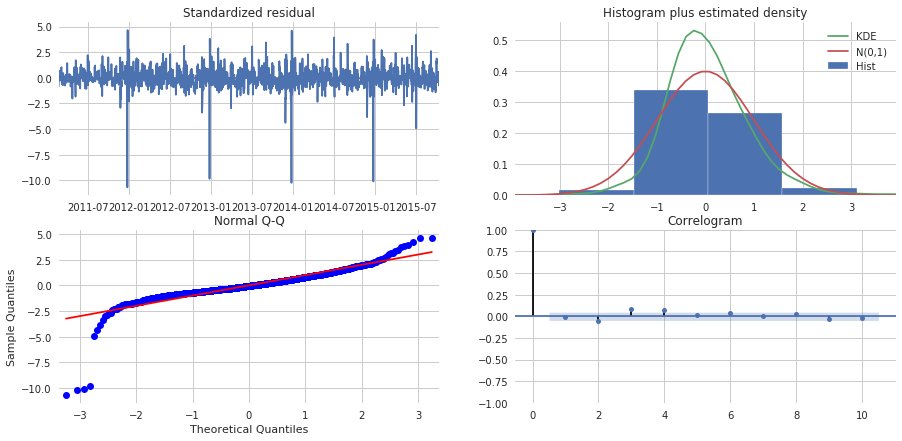

In [ ]:
#Fitting in the SARIMAX Model
#include the exo_train in here , exo_test in prediction (model_fit_SARIMAX) to check results: for now, abandoning their use because
# of the error in package, since even converting exo_train, exo_test into time series/using df results
# in errors. 
#model values earlier 1,1,1, 0,1,1,7 
#values with RMSE - order=(2,1,1), seasonal_order=(2,1,1,7), 
model = SARIMAX(training_p,
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(15,7))
plt.show()
#information on whether particular model is a goodfit
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

The above plots confirm the inferences of the following information:
- The first left plot shows that residual errors fluctuate around a mean of zero and have uniform variance
- The first right plot indicates that density plot also has a mean of almost zero
- The second left plot indicate an almost a perfect fit on red line pointing to the fact that distribution is not skewed
- The low auto-correlation of residuals is indicated in the second right plot. 

### SARIMAX Graphical Validation & Forecasting

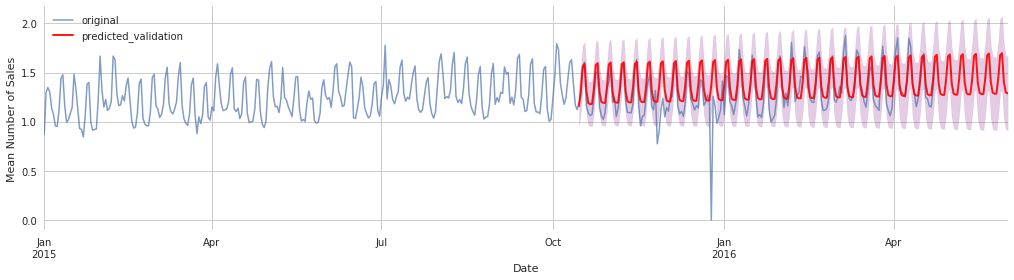

In [ ]:
def model_fit_SARIMAX(model_set, model_fit_srt_tm='2015-10-15', ts_st_tm='2013'):
    
    '''
    makes predictions using SARIMAX model tuned earlier and returns plots along with 
    predictions made
    
    inputs: model_set (model tuned), model_fit_srt_tm (model prediction starting time), 
            ts_st_tm (time series plot to be plotted beginning point)
    returns: forecast plot along with time_series, and pred (predictions made series)
    
    '''
    
    #1.# pred = model_fit.forecast(len(testing_p), alpha=0.05, dynamic=False)  # 95% conf
    pred = model_set.get_prediction(start=pd.to_datetime(model_fit_srt_tm), end='2016-06-01', dynamic=False)
    pred_conf = pred.conf_int()
    #for dynamic prediction of time_series:
    #pred_dy = model_set.get_prediction(dynamic=pred_srt_tm)
    #pred_dy_conf = pred_dy.conf_int()

    # Make as pandas series
    #pred_series = pd.Series(pred, index=testing_p.index)

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

    train_sales_cal_df['avg_sales'][ts_st_tm:].plot(label='original',
                                                  alpha=0.7, 
                                                  lw=1.5 , ax=ax1)
    pred.predicted_mean.plot(label='predicted_validation',
                             alpha=0.9, color='red',
                             lw=2, ax=ax1)
    ax1.fill_between(pred_conf.index, 
                     pred_conf.iloc[:,0], 
                     pred_conf.iloc[:, 1], color='purple', alpha=0.2)
    fig.tight_layout()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Number of Sales')
    plt.legend(loc='upper left')
    plt.show()
    
    return pred

pred_made = model_fit_SARIMAX(model_fit, ts_st_tm='2015')    

Looking at the above graphical representation, we can see that: 
- our model (indicated by green line) provides quite a good enough approximation for modeling the time_series behavior with the maroon background indicating a confidence interval for the new predicted time series. 
- We have applied the model on the test_dataset (data already present in our time series). In the next step, we would try to predict this time series response in the future

In [ ]:
#def forecast_error(prediction, original, date, col):
#    
#    '''
#    returns the Mean Absolute Error (MAE) and root mean square error (RMSE)
#    
#    inputs: prediction (forecasted series, with dates as predicted above), original (orginal time series df), 
#            date (where the model was started for forecast), col(column with time_series_values)
#    
#    returns : MAE, and RMSE 
#    '''
#    forecasted = prediction.predicted_mean
#    original = original.loc[date:, col]
#
#    MAE = np.abs(forecasted - original).mean()
#    RMSE = np.sqrt(((forecasted - original)**2).mean())
#
#    print("The mean absolute error is : {}".format(MAE))
#    print("The root mean square error is : {}".format(RMSE))
#
#
#forecast_error(pred_made, testing_p, '2015-10-15', 'avg_sales')    

In [ ]:
#fitting the model once again now to all the timeseries data (train_sales_cal_df['avg_sales']) available:
#old_values - 2,1,1 & 0,1,2,7
model = SARIMAX(train_sales_cal_df['avg_sales'],
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)

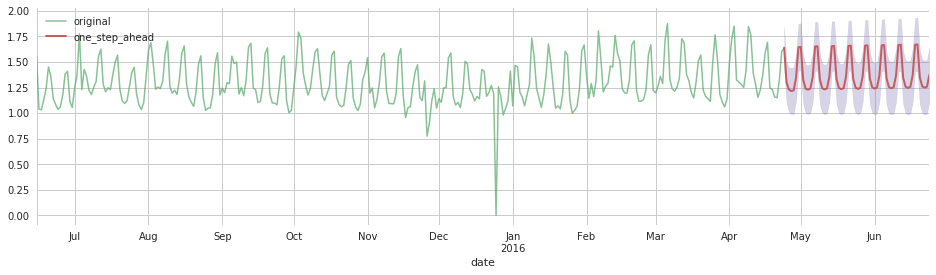

In [ ]:
#Making Future Prediction:
#note: exo_sub = exo.loc['2016-01-25':], if it is needed to provide the holidays , equate exo_sub to exog in get forecast

#pred_future = model_fit.get_forecast(steps=90) #Making Prediction for next 3 months

pred_future = model_fit.get_prediction(start='2016-04-24', end='2016-06-24', dynamic=False)
pred_f_conf = pred_future.conf_int()

fig, ax2 = plt.subplots(figsize=(16, 4))


#now using the entire original series, instead of training or testing:

train_sales_cal_df['avg_sales']['2015-06-15':].plot(label='original',
                 alpha=0.7, 
                 lw=1.5 , color=next(color_cycle), ax=ax2)

pred_future.predicted_mean.plot(label='one_step_ahead',
                 alpha=0.9, 
                 lw=2, color=next(color_cycle), ax=ax2)

ci = pred_f_conf.loc['2016-04-24':]

ax2.fill_between(ci.index, 
                ci.iloc[:,0], 
                ci.iloc[:, 1], color=next(color_cycle), alpha=0.3)

plt.legend(loc='upper left')
plt.show()

The 'original' label represents the timeseries data for which we have the data of average sales available. Whereas the 'one_ahead_label' indicates the forecast made for the time series of average sales, AND the filled background indicates the confidence interval. 

The Forecast is a fairly good response of average number of sales that would be made into the future.

### WRMSSE Calculation

In order to measure the performance of the model, the competition metric has been provided already. This competiton metric can be found at the guidlines provided in the following link. 

WRMSSE is a sales metric that derives itself from RMSSE metric which is a variation on the metric of MASE (mean absolute scaled error). RMSSE specifically evaluate the sales forecast for datasets where heirarchical data level is made available. Since the first dataset of train_sales_val has heirarchical sales data available (i.e.sales divided along product_ids, item_ids, dept_ids, and store_ids level) and one that is also intermittent (i.e. has greater incidence of zero sales in some days while significant sales in other days), RMSSE's utility makes sense. The RMSSE metric also penalizes too large or too small values, therefore it is symmetric. 

\begin{equation}
WRMSSE = \sum_{i=1}^{42840} \left(\frac{W_i}{\sqrt{S_i}} \times \sqrt{\sum{(D)^2}}\right)
\end{equation}

Note: Difference in rolled up vectors is equal to their rolled up difference:
\begin{equation}
Y×M−Y^×M=(Y−Y^)×M=D
\end{equation}

where Y_t is the actual future value of the examined time series at point t, (Y_t ) is the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 



In [ ]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

calendar_df = reduce_mem_usage(calendar_df)

sell_prices_df = reduce_mem_usage(sell_prices_df)

Mem. usage decreased to  0.17 Mb (34.5% reduction)
Mem. usage decreased to 182.68 Mb (30.0% reduction)


In [ ]:
from scipy.sparse import csr_matrix
import gc

NUM_ITEMS = train_sales_df.shape[0]  # 30490
DAYS_PRED = submission_file.shape[1] - 1  # 28

# Dataframe with only last 28 days:
sales = train_sales_df
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# To long form:
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# Add week of year column from 'calendar':
data = pd.merge(data, calendar_df, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# Add weekly price from 'sell_prices':
data = data.merge(sell_prices_df, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# Calculate daily sales in USD:
data['sale_usd'] = data['sale'] * data['sell_price']
data.head()

#this part is correct

,id,store_id,item_id,sale,d,sell_price,category,sale_usd
0,HOBBIES_1_001_CA_1_validation,CA_1,HOBBIES_1_001,1,d_1886,8.257812,HOBBIES,8.257812
1,HOBBIES_1_002_CA_1_validation,CA_1,HOBBIES_1_002,1,d_1886,3.970703,HOBBIES,3.970703
2,HOBBIES_1_003_CA_1_validation,CA_1,HOBBIES_1_003,0,d_1886,2.970703,HOBBIES,0.000000
3,HOBBIES_1_004_CA_1_validation,CA_1,HOBBIES_1_004,0,d_1886,4.640625,HOBBIES,0.000000
4,HOBBIES_1_005_CA_1_validation,CA_1,HOBBIES_1_005,1,d_1886,2.880859,HOBBIES,2.880859


In [ ]:
# List of categories combinations for aggregations as defined in docs:
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id +'_'+ sales.cat_id, sales.state_id +'_'+ sales.dept_id,
                sales.store_id +'_'+ sales.cat_id, sales.store_id +'_'+ sales.dept_id, 
                sales.item_id, sales.state_id +'_'+ sales.item_id, sales.id]


## First element Level_0 aggregation 'all_sales':
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# List of dummy dataframes:
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# Concat dummy dataframes in one go:
## Level is constructed for free.
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# Save values as sparse matrix & save index for future reference:
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_csr.shape

(42840, 30490)

In [ ]:
roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df
gc.collect()

351617

In [ ]:
# Fucntion to calculate S weights:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    # Rollup sales:
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    sales_train_val = roll_mat_csr * sales[d_name].values

    no_sales = np.cumsum(sales_train_val, axis=1) == 0
    sales_train_val = np.where(no_sales, np.nan, sales_train_val)

    # Denominator of RMSSE / RMSSE
    weight1 = np.nanmean(np.diff(sales_train_val,axis=1)**2,axis=1)
    
    return weight1

In [ ]:
S = get_s(drop_days=0)
S.shape

(42840,)

In [ ]:
# Functinon to calculate weights:
def get_w(sale_usd):
    """
    """
    # Calculate the total sales in USD for each item id:
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # Roll up total sales by ids to higher levels:
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)

In [ ]:
W = get_w(data[['id','sale_usd']])
W.shape

(42840,)

In [ ]:
# Predicted weights
##W_df = pd.DataFrame(W,index = roll_index,columns=['w'])

# Load the original weights:
##data_pass = '/kaggle/input/original-weights/'
##W_original_df = pd.read_csv(data_pass+'weights_validation.csv')

# Set new index, calculate difference between original and predicted:
##W_original_df = W_original_df.set_index(W_df.index)
##W_original_df['Predicted'] = W_df.w
##W_original_df['diff'] = W_original_df.Weight - W_original_df.Predicted

# See where we are off by more than e-6
##m = W_original_df.Weight.values - W_df.w.values > 0.000001
##W_original_df[m]

In [ ]:
SW = W/np.sqrt(S)
sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

In [ ]:
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T


# Function to calculate WRMSSE:
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw)/12 #<-used to be mistake here
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))/12 #<-used to be mistake here
        return score, score_matrix

### **Prophet Time Series Modeling**
Prophet is a time-series forecasting tool developed by facebook team that has advanced capabilities to predict the time series data taking into consideration the weekly, monthly or yearly data seasonality. Prophet also has advanced capability to implement custom changepoints observed in time series data as well as specify holiday points where trends are continuously changing.

In [ ]:
#dates_s = [pd.to_datetime(calendar_df.loc[calendar_df['d'] == str_date,'date'].values[0]) for str_date in d_cols]


In [ ]:
#df_sale_group_item = train_sales_df[np.hstack([['dept_id','store_id'],d_cols])].groupby(['dept_id','store_id']).sum()
#df_sale_group_item = df_sale_group_item.reset_index()

#item_series =  df_sale_group_item[(df_sale_group_item.dept_id == 'FOODS_1') & (df_sale_group_item.store_id == 'TX_1')]
#dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
#dates['y'] = item_series[d_cols].values[0].transpose() 

### Fb Prophet: Training and Validation Data Split

In [ ]:
#prophet forecast from here
from fbprophet import Prophet
from tqdm.notebook import tqdm as tqdm

####Observing behavior of Avg Number of Sales using Prophet#######
####Converting the data into required ds and y format for Prophet Model#####

ts = train_sales_cal_df[['avg_sales']].reset_index()
ts = ts.set_axis(['ds', 'y'], axis=1, inplace=False)

#####Specifying data for only one year to better visulize future predictions#######
threshold_date = pd.to_datetime('2015-04-22') 
select_d = ts ['ds'] > threshold_date

ts = ts[select_d][['ds', 'y']]

#####prophet_plot(ts)######

mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
sales_model = Prophet(**mod_params, interval_width=0.95)
#data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

######fitting the prophet model########

sales_model.fit(ts)
future = sales_model.make_future_dataframe(28, 'D')
#future['cap'] = data['cap'].max() #incase logistic model growth used in params
sales_forecast = sales_model.predict(future)

########Train/Test split of Data#######################

threshold_date = pd.to_datetime('2016-03-01') #for the test/validation split
forecast_date = pd.to_datetime('2016-04-24') #for the actual forecast date to begin
select_d = ts ['ds'] < threshold_date

ts_train = ts[select_d][['ds', 'y']]
ts_test = ts[~ select_d][['ds', 'y']]

select_d2 = sales_forecast['ds'] < forecast_date


forecast_train = sales_forecast[select_d2]
forecast_test = sales_forecast[~ select_d2]


### Prophet Forecasting On Average Sales Using Seaborn

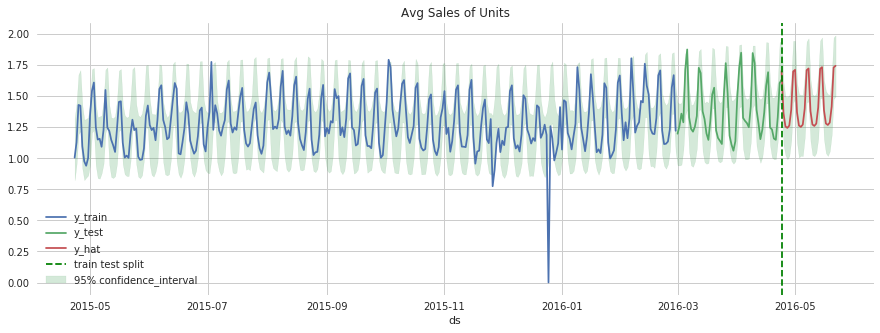

In [ ]:
#Seaborn based plot for the fb_Prophet Model
sns.set_style('whitegrid')
sns_c = sns.color_palette(palette='deep')

fig, ax = plt.subplots(figsize=(15,5))

ax.fill_between(
    x=sales_forecast['ds'], y1=sales_forecast['yhat_lower'], y2=sales_forecast['yhat_upper'],
    color=sns_c[2],  alpha=0.25, label=r'95% confidence_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=ts_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=ts_test, ax=ax)
#sns.lineplot(x='ds', y='yhat', label='y_hat', data=sales_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.axvline(forecast_date, color='g', linestyle='--', label='train test split')

ax.legend(loc='lower left')
ax.set(title='Avg Sales of Units', ylabel='');

The above plot indicates the prophet model forecasting using average number of sales as a dependent variable. The plot indicatest that:
- y_train(blue line plot) represents the training set data
- y_test (green line ) is representative of validation data response
- y_hat (red line) is a modeled response obtained using the Prophet Prediction Model
- green filled area represents the 95 % confidence interval for the plot 

### Prophet Forecast Using Individual Product IDs

In [ ]:
#selecting the product ids for which we require prophet prediction

id1 = 'FOODS_3_443_CA_1_validation'
id2 =  'HOUSEHOLD_1_005_CA_3_validation'
id3 =  'FOODS_3_823_WI_3_validation'
id4 = 'FOODS_3_090_CA_3_validation'
id5 = 'FOODS_3_586_TX_2_validation'
id6 = 'FOODS_3_586_TX_3_validation'

#train_sales_cal_df[id2]


In [ ]:
def make_id_timeseries(idx, date='2016-02-22'):
    
    '''
    selects and makes the timeseries adjusted for fb prophet model by adjusting names
    of columns
    
    inputs: product_id
    
    returns: time series with data specified in format for prophet
    
    '''
    
    dates_series = [date for date in train_sales_cal_df.index]
    id_series =  train_sales_df[(train_sales_df.id == idx )]
    item_ts = pd.DataFrame({'ds': dates_series}, index=range(len(dates_series)))
    item_ts['y'] = id_series[d_cols].values[0].transpose()
    
    ######Following steps would shorten the behavior of historic timeline data########
    ######Choosing the threshold date near to the date where prediction needs to be made 
    ######because of close correlation in time series
    
    threshold_date = pd.to_datetime(date) 
    mask = item_ts['ds'] > threshold_date

    item_ts = item_ts[mask][['ds', 'y']]
    
    return item_ts

data1 = make_id_timeseries(id6)
data4 = make_id_timeseries(id4)

In [ ]:
#weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
#e = ((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ (weighted_coeff*df_cv['y'])
#resulting_wmape = pd.DataFrame(df_cv['yhat'], df_cv['y'], weighted_coeff, e)
##print("yhat:{}, actual:{}, coeff:{}, error:{}".format(df_cv['yhat'], df_cv['y'], weighted_coeff, e))
#data = {'yhat':list(df_cv['yhat']),
#        'actual':list(df_cv['y']),
#        'diff' : list(df_cv['yhat'] - df_cv['y']),
#       'weighted_coef': list(weighted_coeff), 
#       'error': list(e)}
#  
# Create DataFrame
#pd.DataFrame(data)

### Custom Loss Function For Fb Prophet Tuning

In [ ]:
##########New Code Working For Custom Error###########
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Note : the code was generated using the explanation at the following link
#https://www.baeldung.com/cs/mape-vs-wape-vs-wmape

def fbprophet_tuning_per_single_id(id_data, changepoint_prior_list=[0.5, 0.6, 0.7], 
                                   changepoint_range_list=[0.6, 0.7, 0.8], 
                                   n_changepoints_list=[50, 60]):
    param_grid = {  
        'changepoint_prior_scale': changepoint_prior_list,
        'changepoint_range': changepoint_range_list,
        'n_changepoints' : n_changepoints_list
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #wapes = []  # Store the RMSEs for each params here
    wmapes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        mod = Prophet(**params).fit(id_data)  # Fit model with given params
        df_cv = cross_validation(mod, initial = '32 days', period = '3 days', horizon='28 days')
        #df_p = performance_metrics(df_cv, rolling_window=1)
        #rmses.append(df_p['rmse'].values[0])
        #wapes.append(np.sum(df_cv['yhat'] - df_cv['y']) / (np.sum(df_cv['y'])))
        weighted_coeff = (df_cv['yhat'] - df_cv['y'])/(df_cv['yhat'] - df_cv['y']).mean()
        wmapes.append(np.sum((df_cv['yhat'] - df_cv['y']) * weighted_coeff )/ np.sum(weighted_coeff*df_cv['y']) )

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['wmape'] = wmapes
    print(tuning_results)
    
fbprophet_tuning_per_single_id(data1)    

    changepoint_prior_scale  changepoint_range  n_changepoints     wmape
0                       0.5                0.6              50  0.503055
1                       0.5                0.6              60  0.503055
2                       0.5                0.7              50  0.700986
3                       0.5                0.7              60  0.700986
4                       0.5                0.8              50  1.505614
5                       0.5                0.8              60  1.505614
6                       0.6                0.6              50  0.535218
7                       0.6                0.6              60  0.535218
8                       0.6                0.7              50  0.716194
9                       0.6                0.7              60  0.716194
10                      0.6                0.8              50  1.664200
11                      0.6                0.8              60  1.664200
12                      0.7                0.6     

<Figure size 1080x216 with 0 Axes>

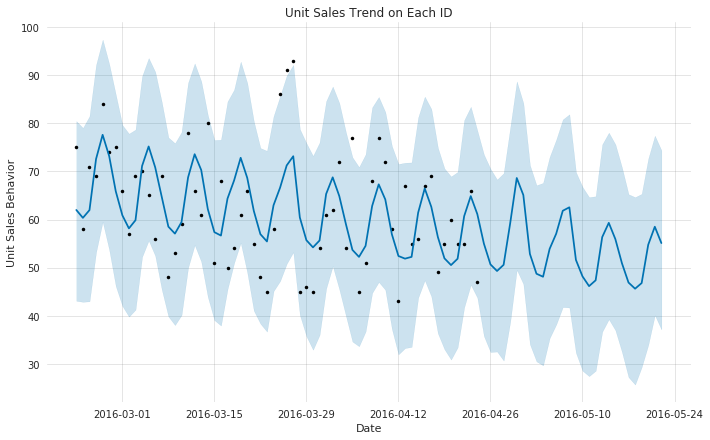

<Figure size 1080x216 with 0 Axes>

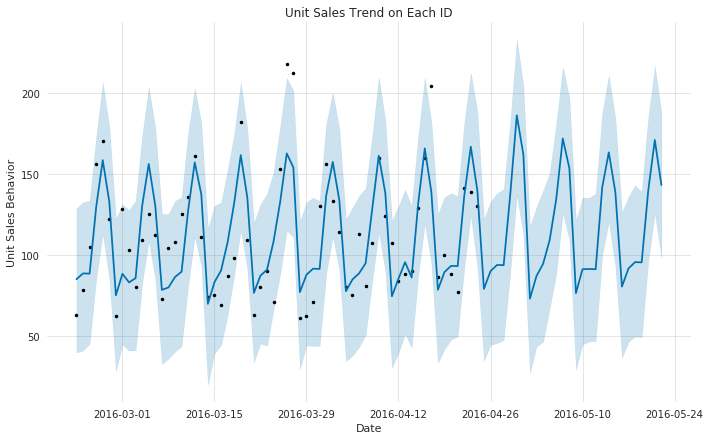

In [ ]:
def prophet_plot(data, periods=28, freq='D'):
    
    '''
    plots the fb prophet model for the data of id specified
    
    inputs: data (product id along with data for previous days), periods(predictions for 
    the next days to be made)
    
    returns: plots the immediate historic data along with forecast for the future made
    '''
    
    mod_params = { 'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 

    sales_model = Prophet(**mod_params, holidays=holidays, interval_width=0.95)
    #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used
    #fitting the model
    sales_model.fit(data)
    future = sales_model.make_future_dataframe(periods, freq)
    #future['cap'] = data['cap'].max() #incase logistic model growth used in params

    sales_forecast = sales_model.predict(future)
    
    plt.figure(figsize=(15,3))
    #fig, ax = plt.subplots(figsize=(14,5))
    sales_model.plot(sales_forecast, xlabel='Date', ylabel='Unit Sales Behavior')
    #plt.axvline(x=sales_forecast[sales_forecast.ds == '2016-04-22']['ds'], color='r')
    #ax.axvline(threshold_date, color='g', linestyle='--', label='Prediction Onwards')
    #ax.legend(loc='upper left')
    #ax.set(title='Avg Sales of Units', ylabel='');
    plt.title("Unit Sales Trend on Each ID")
    plt.show()


prophet_plot(data1)
prophet_plot(data4)    

These prophet plots of the individual product_ids indicate that the prophet model does quite a significantly better job at predicting the future response of the number of sales for each product_id. 

We are going to use prophet model at predicting number of sales for individual ids because it would provide us with a better suited data for participation into the competition than say, using an average of sales for each product, as we did in SARIMAX.

In [ ]:
all_ids = train_sales_cal_df.columns.drop(['daysnum', 'avg_sales'])
sales_forecast_list = []

def prophet_pred_df(start=15500, end=15650):
    '''
    makes a dataframe with prophet predictions made for each product_id 
    
    input: start = product_id start, end = product_id to be the last one for prediction
    
    returns: dataframe with predictions made for the next 28 days using prophet of the product
             ids specified in input
    '''

    for idc in tqdm(range(start, end)):
        train_sub = train_sales_cal_df.iloc[-28:, idc].reset_index()
        idx = train_sub.columns[1]
        train_sub.set_axis(['ds', 'y'], axis=1, inplace=True)
        mod_params = { 'changepoint_prior_scale': 0.5 , 'changepoint_range': 0.6,
                      'n_changepoints': 50, 
                      'weekly_seasonality': True, 'seasonality_mode': 'multiplicative'} 
        sales_model = Prophet(**mod_params, interval_width=0.95)
        #data['cap'] = data['y'].max() + data['y'].std() * 0.05 #incase logistic model growth used

        ######fitting the prophet model########
        
        sales_model.fit(train_sub)
        future = sales_model.make_future_dataframe(28, 'D')
        #future['cap'] = data['cap'].max() #incase logistic model growth used in params
        sales_forecast = sales_model.predict(future)[-28:]
        sales_forecast_list.append( (np.append(np.array([idx]), sales_forecast['yhat'].values.transpose())) )
    
    return sales_forecast_list

#list_table would collect all entries

list_table = prophet_pred_df()

In [ ]:
#changing column names to those as specified in submission file
df_prophet_forecast = pd.DataFrame(list_table)
df_prophet_forecast.columns = submission_file.columns
#df_prophet_forecast = df_prophet_forecast.round(decimals = 2)
df_prophet_forecast.head(6)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_262_TX_2_validation,-0.09116952560124425,-0.3214832336878263,-0.09617118096117233,0.5401947999878096,-0.11503421153322309,2.0639741881017617,-0.13142741103741326,-0.16905312459479868,-0.5662467773369758,...,-0.24710445921365,4.2540151529129755,-0.26105751239967984,-0.3248203225938537,-1.055773864651626,-0.2942850967438146,1.553593102954212,-0.3131395830629984,5.3490356353200745,-0.32587256307968904
1,HOBBIES_1_263_TX_2_validation,-0.0031262053895670934,-0.0016539338879315137,0.005335209677856929,-0.01896995249937965,0.0032039918484059477,-0.07519392977930246,-0.07103649870729058,0.0071762590814138235,0.008645473872747575,...,0.027115619910011213,-0.4412407518542682,-0.32762472545546184,0.027781188023836823,0.02924428939482873,-0.8974993933941853,-0.4737796431882676,0.03907143394214745,-0.624264162891576,-0.4559188388290327
2,HOBBIES_1_264_TX_2_validation,0.568760536983978,0.25940467440698656,0.2597781504942081,0.4026456528250222,1.0584044472324778,0.6566933342376823,0.7423922227849149,0.6316917919811199,0.2876602200126393,...,1.2786934471816132,0.7913707523941584,0.8924469948558804,0.7575543019770551,0.34417131122645245,0.3433661455817126,0.5302485125141344,1.388837947155774,0.8587094614713319,0.9674743808908013
3,HOBBIES_1_265_TX_2_validation,0.27281928063675764,0.19388097774868757,0.00028439183092259364,0.15098289941629753,0.14003613544149496,0.2126461837432968,0.2502917249466674,0.13024561866223489,0.08438545709527487,...,-0.06864543214016595,-0.14198683245085977,-0.2235709607858748,-0.15490170528753486,-0.134605584212191,-0.00023973038880288668,-0.1540411345809301,-0.17298621593128768,-0.31930334054830706,-0.46050230365219574
4,HOBBIES_1_266_TX_2_validation,1.1223410661085351,0.42754482334959376,2.7022023589672,1.8426742496954014,2.7033009175505764,5.193095580532868,5.553925162315944,1.3325855593774008,0.505547962270953,...,3.6181708170045055,6.909097583882046,7.346841541781331,1.7530745459058321,0.6615542401230878,4.143638213671256,2.8012624972989517,4.075605766727042,7.767098585558123,8.243299731511543
5,HOBBIES_1_267_TX_2_validation,-0.04549276588916104,-0.04298176580850032,1.256567143573097,0.46915918974281196,-0.03323396784213866,0.821282253781305,1.0693451636252778,-0.061257145543575225,-0.05717348069569129,...,-0.05245978210224882,1.277539959821553,1.6407386745220356,-0.09278590485472629,-0.08555691046716214,2.4451815379329447,0.893818821094127,-0.0620726892349892,1.5056688128417266,1.926435429969099


In [ ]:
########Remove Unwanted Columns###################
train_sales_df = train_sales_df.drop(['total_sales_all_days', 'avg_sales_all_days', 'median_sales_all_days'], axis=1)

###########Making the dataframe of predictions for all ids############
req_sales_df = train_sales_df.iloc[:, np.r_[0,-28:0]].melt('id', var_name='d', value_name='sale')
req_sales_df = req_sales_df.merge(calendar_df.loc[:,['d','date','wday']])
#req_sales_df
lastest_date = int(req_sales_df.d.max()[2:])
req_sales_df = req_sales_df.groupby(['id','wday'])['sale'].mean()
req_sales_df.head(7)

id                           wday
FOODS_1_001_CA_1_validation  1       0.75
                             2       0.50
                             3       3.00
                             4       0.75
                             5       1.50
                             6       0.25
                             7       1.50
Name: sale, dtype: float64

In [ ]:
###########Generating Submission Dataframe of ids for 28 next days with 0 values############

mv_avg_forecast = submission_file.copy()
mv_avg_forecast.columns = ['id'] + ['d_' + str(lastest_date + x) for x in range(1, 29)]
mv_avg_forecast = mv_avg_forecast.loc[mv_avg_forecast.id.str.contains('validation')]
#mv_avg_forecast

In [ ]:
###########Generating Dataframe for Moving Average Values###############

mv_avg_forecast = mv_avg_forecast.melt('id', var_name='d', value_name='sale')
mv_avg_forecast = mv_avg_forecast.drop('sale',axis = 1)
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.merge(calendar_df.loc[:,['d','date','wday']])
mv_avg_forecast = mv_avg_forecast.join(req_sales_df, on=['id', 'wday'])
#mv_avg_forecast

mv_avg_forecast = mv_avg_forecast.pivot(index='id', columns='d', values='sale')
mv_avg_forecast = mv_avg_forecast.reset_index()
mv_avg_forecast

d,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1_001_CA_1_validation,3.00,0.75,1.50,0.25,1.50,0.75,0.50,3.00,0.75,...,1.50,0.75,0.50,3.00,0.75,1.50,0.25,1.50,0.75,0.50
1,FOODS_1_001_CA_2_validation,0.25,0.50,1.25,1.00,0.25,0.00,4.50,0.25,0.50,...,0.25,0.00,4.50,0.25,0.50,1.25,1.00,0.25,0.00,4.50
2,FOODS_1_001_CA_3_validation,0.25,0.00,0.50,0.00,0.00,1.50,3.75,0.25,0.00,...,0.00,1.50,3.75,0.25,0.00,0.50,0.00,0.00,1.50,3.75
3,FOODS_1_001_CA_4_validation,1.25,0.00,0.25,0.00,0.25,0.25,0.25,1.25,0.00,...,0.25,0.25,0.25,1.25,0.00,0.25,0.00,0.25,0.25,0.25
4,FOODS_1_001_TX_1_validation,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,...,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.25,...,0.00,0.25,0.50,0.25,0.25,0.50,0.25,0.00,0.25,0.50
30486,HOUSEHOLD_2_516_TX_3_validation,0.00,0.50,0.50,0.00,0.00,0.25,0.00,0.00,0.50,...,0.00,0.25,0.00,0.00,0.50,0.50,0.00,0.00,0.25,0.00
30487,HOUSEHOLD_2_516_WI_1_validation,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,...,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00
30488,HOUSEHOLD_2_516_WI_2_validation,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00


In [ ]:
#del mv_avg_forecast.index.name
mv_avg_forecast.rename_axis(None).index.name
mv_avg_forecast.head(4)

d,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,FOODS_1_001_CA_1_validation,3.00,0.75,1.50,0.25,1.50,0.75,0.50,3.00,0.75,...,1.50,0.75,0.50,3.00,0.75,1.50,0.25,1.50,0.75,0.50
1,FOODS_1_001_CA_2_validation,0.25,0.50,1.25,1.00,0.25,0.00,4.50,0.25,0.50,...,0.25,0.00,4.50,0.25,0.50,1.25,1.00,0.25,0.00,4.50
2,FOODS_1_001_CA_3_validation,0.25,0.00,0.50,0.00,0.00,1.50,3.75,0.25,0.00,...,0.00,1.50,3.75,0.25,0.00,0.50,0.00,0.00,1.50,3.75
3,FOODS_1_001_CA_4_validation,1.25,0.00,0.25,0.00,0.25,0.25,0.25,1.25,0.00,...,0.25,0.25,0.25,1.25,0.00,0.25,0.00,0.25,0.25,0.25


In [ ]:
#df_sub_valid = pd.concat([mv_avg_forecast, df_prophet_forecast_1, 
#                        df_prophet_forecast_2,df_prophet_forecast_3, 
#                        df_prophet_forecast_4, df_prophet_forecast_5, 
#                        df_prophet_forecast_6], sort=False)

#re-adjusting the old columns against new-ones

mv_avg_forecast.columns = submission_file.columns

df_valid = pd.concat([mv_avg_forecast[~mv_avg_forecast.id.isin(df_prophet_forecast.id)], df_prophet_forecast], sort=False)

df_eval = df_valid.copy()
df_eval['id'] = df_eval['id'].str.replace("validation", "evaluation")

submission_df = pd.concat([df_valid, df_eval], sort=False)
submission_df = submission_df.sort_values('id')


In [ ]:
submission_df.columns

Index(['id', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype='object')

In [ ]:
#submission_df.columns = ['id'] + ['F' + str(x) for x in range(1, 29)]
#submission_df

### WRMSSE Error Calculation on Prediction

In [ ]:
#DAYS_PRED = 28
dayCols = ["d_{}".format(i) for i in range(1914-DAYS_PRED, 1914)]
y_true = train_sales_df[dayCols]

In [ ]:
df_valid_w = df_valid.drop('id', 1)
for col in df_valid_w.columns:
    df_valid_w[col] = pd.to_numeric(df_valid_w[col], errors='coerce')#.convert_dtypes() cp95 solution recommends using convertdtypes if nan present

In [ ]:
wrmsse(y_true, df_valid_w, score_only=True)

2.516726161751836

### Final Submission File Preparation

In [ ]:
# Fix negative forecast
num = submission_df._get_numeric_data()
num[num < 0] = 0
# Prepare the submission file
submission_df.to_csv('submission.csv', index=False)

print(f'Submission shape: {submission_df.shape}')

Submission shape: (60980, 29)


In [ ]:
#kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "from 450 to 600"

The resullts will be compiled here :
- First file with 50 ids prediction from 500 to 550 had an accuracy of 0.752
- Second file with 260 (from 20 to 280) ids and holidays included had accuracy of 0.758
- Third file with holidays removed, and 310 ids yields a public score of 0.754
- Fourth file with simple moving average chosen yields a public leaderboard score of 1.082
- Fifth file with product ids ranging from 350th to 1000th yielded a public leaderboard score of 0.7576
- Sixth submission with product ids from 450th to 600th resulted in public leaderboard score of 0.7531
- Seventh submission with product ids ranging from 15500th to 16000th gave a public leaderboard score 0.752
- Eighth submission file with product ids ranging from 15500th to 17000th (almost 1500 product ids) using prophet forecast, resulted in public leaderboard score improvement for 0.738

## Further Recommendations on Improvement

Usingh the prophet model along with a general moving average prediction for rest of the ids not predicted using prophet model were used to make forecast for the next 28 days. However, the accuracy score from kaggle private leaderboard has come out to be around 0.73. There are a few other kernels that have described ways to improve this further

Please Feel Free to Improve Upon this notebook and give your feedback

- Run the model of prophet forecast for atleast 1/3rd of the all product ids to explore its potential of improving the forecast , using a fast machine.
- Use another model implementation such as LightGBM, Convolution NN to improve the score
- Make new features with rolling mean as well as a lag feature that have been observed to improve score when using models such as lightgbm

## References and Further Readings:

Quite a few resources proved helpful while others that offered more opportunity for learning are mentioned below

- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://towardsdatascience.com/time-series-forecasting-a-getting-started-guide-c435f9fa2216
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://facebook.github.io/prophet/docs/diagnostics.html
- https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067
- Special thanks to the kernel of TSURU https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm#WRMSSE-calculation
- Specal thanks to the kernel of sibmike for making WRMSSE calculation faster https://www.kaggle.com/mubashir1/fast-clear-wrmsse-18ms/edit
- https://www.kaggle.com/binhlc/forecasting-multiple-time-series-using-prophet
- https://www.kaggle.com/tnmasui/m5-wrmsse-evaluation-dashboard

**=============++++++================**